# Adversarial Attacks Vignette
## Contributors: Owen P., Parker R., Edwin Y., Eric Z., Henry L.

## What is an Adversarial Attack?
Adversarial attacks is a technique used to decieve machine learning models by employing "defective" inputs. The result of these altered inputs is the misclassification of the input. Typically these adversarial attack techniques change the inputs in a way that is indistinguishable to the human eye, but causes the model to fail to properly identity the contents of the image. The concept of adversarial attacks is typically described as the optimization problem:
$$\text{minimize } \delta \text{ such that F}(x+\delta) \neq l$$
where $\delta$ is the small perturbation, F is a classification neural network, $x$ is the data you are attacking and $l$ is the class that $x$ is supposed to belong to.

## Method: Fast Gradient Sign Method
There are many adversarial attacks, for our vignette we will be using the fast gradient sign method (FGSM), but many of the concepts are applicable to other methods. This method uses the gradient of the loss function with respect to the input data to create adversarial inputs. This gradient is then scaled by a small amount, typically around .05 to .2, and then added to the original image.

## Example: CIFAR10
In order to show how adversarial attacks work, will will show an example using the CIFAR10 dataset. The data set was produced by the Canadian Institute for Advanced Research and is comprised of 60,000 color images that belong to 10 different classes. The 10 different classes are airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Each image is 32x32 pixels with each pixel having a red channel, green channel, and blue channel value.

In [4]:
# Importing required packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Data
Since the CIFAR10 data set is widly used a a benchmark data set, it is already built into tensorflow keras. Below is how to download, load, and partition the data set.

In [5]:
# Downloading the dataset
cifar = tf.keras.datasets.cifar10

# loading and partitioning the data set
(X_train, y_train), (X_test, y_test) = cifar.load_data()


# Preprocessing
After loading the data set, we must preprocess the data set so we can fit a convolutional neural network to it. Note that the images are 32 by 32 pixels each with 3 channels and there are 10 different classes for the predicting classes. There are also examples of the processed data.

In [6]:
# image variables for sizing
img_size = 32
img_chan = 3
n_classes = 10

# Reshaping the training data 
X_train = np.reshape(X_train, [-1, img_size, img_size, img_chan])
X_train = X_train.astype(np.float32) / 255

# Reshaping the testing data
X_test = np.reshape(X_test, [-1, img_size, img_size, img_chan])
X_test = X_test.astype(np.float32) / 255

# converting the labels to categorical values
to_categorical = tf.keras.utils.to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Here is example on how the images look and how one would create a png of the image using mathplotlib.

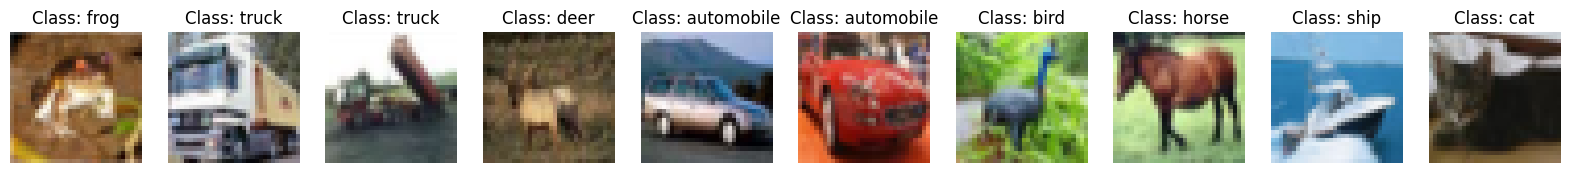

In [7]:
# Showing some of the raw data
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
index_true_0 = class_labels[np.where(y_train[0] == 1)[0][0]]
index_true_1 = class_labels[np.where(y_train[1] == 1)[0][0]]
index_true_2 = class_labels[np.where(y_train[2] == 1)[0][0]]

# Plot the results
plt.figure(figsize=(20, 3))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Class: {class_labels[np.where(y_train[i] == 1)[0][0]]}")
    plt.axis('off')

plt.show()


# Creating a Convolutional Neural Network
Now that the data is cleaned and partitioned we fit a neural network to it. The neural network has a simple model with only two convolutional layers. It is important to note that there are neural networks that are able to achieve far higher accuracy, but research has found that high accuracy on clean data does not impact the preformance of adversarial attacks.

In [8]:
tf.random.set_seed(0)

# Tensorflow Keras Model with 2 Convolution Layers and Max Pooling
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

C:\Users\edwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1184/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3926 - loss: 1.6807

KeyboardInterrupt: 

## Creating the FGSM
Now that we have a model, we can create a Fast Gradient Sign Method (FGSM) attack to attack our CNN. Below is the fgsm function that takes all the parameters from earlier, image, label, and model, and determines the loss of the models performance. After it has determined the loss it calculates the gradient then signed gradient to add onto the original image with some magnitude, epsilon. This creates the "attacked" image.

In [ ]:
def fgsm_attack(image, label, model, epsilon):
    """
    Generates adversarial examples using FGSM.
    
    image: tf.Tensor
        Input image to perturb, shape (1, 32, 32, 3).
    label: tf.Tensor
        True label of the image, shape (1, 10).
    model: tf.keras.Model
        The trained model.
    epsilon: float
        The strength of the perturbation.
    """
    
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    
    # Ensure the image has a gradient
    with tf.GradientTape() as tape:
        tape.watch(image)  # Watch the input image
        prediction = model(image)  # Get model predictions
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)  # Compute loss

    # Calculate gradients of loss w.r.t. the image
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)  # Get sign of gradients

    # Generate the adversarial example
    adv_image = image + epsilon * signed_grad
    adv_image = tf.clip_by_value(adv_image, 0, 1)  # Keep the pixel values in [0, 1]
    
    return adv_image, signed_grad


## Testing FGSM on CIFAR10
Now that we have the altered image, we will test our results and see if that FGSM attack actually affected the CNN. Below is a script that will use the FGSM on a batch of images and then display the results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


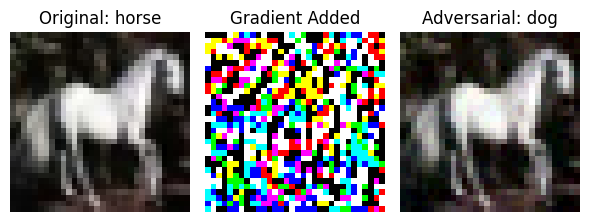

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


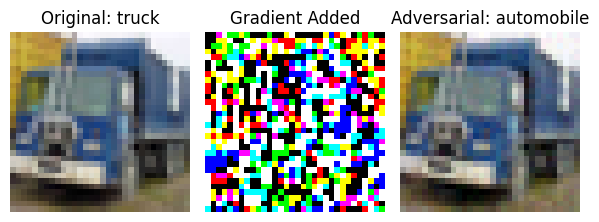

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


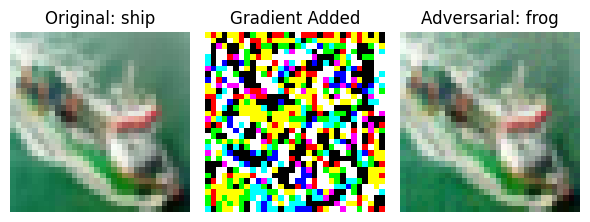

In [ ]:


def test_fgsm_attack(index = 0, num = 5, epsilon = 0.02):
    """
    Tests FGSM attack on a batch of images and visualizes the results.
    Displays the images below
    
    index: integer
        The starting index for the batch of images
    num: integer
        The number of images in the batch
    epsilon: float
        Strength of the FGSM attack.
    """
    for i in range(index, index + num):  # Visualize 5 examples
        image = X_test[i:i+1]  # Select one image (add batch dimension)
        label = y_test[i:i+1]  # True label of the image

        # Generate adversarial example
        adv_image, signed_grad = fgsm_attack(image, label, model, epsilon)

        # Get predictions for both clean and adversarial images
        clean_pred = model.predict(image)
        adv_pred = model.predict(adv_image)

        clean_class = class_labels[np.argmax(clean_pred)]
        adv_class = class_labels[np.argmax(adv_pred)]

        # Plot the results
        plt.figure(figsize=(6, 3))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(image[0])
        plt.title(f"Original: {clean_class}")
        plt.axis('off')

        # Signed Gradient image
        plt.subplot(1, 3, 2)
        plt.imshow(signed_grad[0] * 0.5 +0.5)
        plt.title(f"Gradient Added")
        plt.axis('off')

        # Adversarial image
        plt.subplot(1, 3, 3)
        plt.imshow(adv_image[0])
        plt.title(f"Adversarial: {adv_class}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        # plt.savefig(f'../img/fgmt_img{num + i}.png')
        

test_fgsm_attack(index = 13, num = 3, epsilon = 0.02)

The FGSM attack was really effective. All the example images that we altered with a gradient caused the convolution neural network to misclassify the images. It is important to note that we can still visibly detect the noise that was created in the attack, but it still shows the power of adversarial attacks. FGSM is a relatively basic method for creating adversarial attacks. Newer methods use iterative steps that closely resemble FGSM, such as the Projected Gradient Descent, which applies multiple small perturbations instead of one large perturbation. In the case of FGSM, it's a relatively simple method in showcasing the power of adversarial attacks, being able to alter the labels of almost all images. 

$$\textbf{References}$$

Krizhevsky, A., Nair, V., & Hinton, G. (2009). The CIFAR-10 dataset. Retrieved December 5, 2024, from https://www.cs.toronto.edu/~kriz/cifar.html

Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo,
Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,
Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow,
Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,
Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,
Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,
Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,
Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,
Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,
Yuan Yu, and Xiaoqiang Zheng.
TensorFlow: Large-scale machine learning on heterogeneous systems,
2015. Software available from tensorflow.org.

Chollet, F., & others. (2015). Keras. GitHub. Retrieved from https://github.com/fchollet/keras